## Introduction

This notebook contains an analysis on the telecommunication [dataset](https://dataverse.harvard.edu/dataverse/bigdatachallenge?q=&types=datasets&sort=dateSort&order=desc&page=1 ) from the Telecom Italia first edition of the Big Data Challenge contest which was designed to stimulate the creation and development of innovative technological ideas in the Big Data field. Exhaustive description and information about the data can be obtained from this [link](https://www.nature.com/articles/sdata201555?hash=152d20bc-ea8b-4a2e-af80-c4777b3c12b1). Due to our limitation on resources, we limited our analysis to the ```sms-call-internet-mi-2013-11-01.txt``` file. Analysis steps are outlined as observed from the table of contents above.


### Import Useful Libraries

In [1]:
import pandas as pd # data reading, processing operations
import numpy as np # linear algebra operations
import seaborn as sns #Different graph plotting
import matplotlib.pyplot as plt#plotting library
from collections import Counter 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import datetime
sns.set_style("ticks")
sns.set_context("paper")
pd.options.display.max_columns = 10000

### Load Dataset

In [2]:
# Read the data with pandas that are seperated by tab '\t' character
# sci = pd.read_csv('sms-call-internet-mi-2013-11-01.txt', sep='\t',  header=None)
# sci.to_csv('sms_call_internet.csv',index=False)

data_sci = pd.read_csv('sms_call_internet.csv')
sci_ = data_sci.copy()
print(sci_.shape)
sci_.head()

(4842625, 8)


,0,1,2,3,4,5,6,7
0,1,1383260400000,0,0.081363,NaN,NaN,NaN,NaN
1,1,1383260400000,39,0.141864,0.156787,0.160938,0.052275,11.028366
2,1,1383261000000,0,0.136588,NaN,NaN,0.027300,NaN
3,1,1383261000000,33,NaN,NaN,NaN,NaN,0.026137
4,1,1383261000000,39,0.278452,0.119926,0.188777,0.133637,11.100963


Here, as shown above the column names are given as numbers. Thus, the column names are obtained from the information provided in the [link](https://www.nature.com/articles/sdata201555?hash=152d20bc-ea8b-4a2e-af80-c4777b3c12b1) and changed accordingly.

In [3]:
# rename columns and print first 5 rows
ft = ['square_id','time_interval','country_id','sms_in_activity',
              'sms_out_activity','call_in_activity','call_out_activity',
              'internet_traffic_activity']
sci_.columns = ft
print('+=+'*30)
print(f"There are {sci_.shape[0]} observations and {sci_.shape[1]} features in this dataset.")
print('+=+'*30)
sci_.head()

+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+
There are 4842625 observations and 8 features in this dataset.
+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+


,square_id,time_interval,country_id,sms_in_activity,sms_out_activity,call_in_activity,call_out_activity,internet_traffic_activity
0,1,1383260400000,0,0.081363,NaN,NaN,NaN,NaN
1,1,1383260400000,39,0.141864,0.156787,0.160938,0.052275,11.028366
2,1,1383261000000,0,0.136588,NaN,NaN,0.027300,NaN
3,1,1383261000000,33,NaN,NaN,NaN,NaN,0.026137
4,1,1383261000000,39,0.278452,0.119926,0.188777,0.133637,11.100963


We check on the general information about the data including the total number of observations, data types and total number of columns.

In [4]:
sci_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4842625 entries, 0 to 4842624
Data columns (total 8 columns):
square_id                    int64
time_interval                int64
country_id                   int64
sms_in_activity              float64
sms_out_activity             float64
call_in_activity             float64
call_out_activity            float64
internet_traffic_activity    float64
dtypes: float64(5), int64(3)
memory usage: 295.6 MB


It can be observed from the information above that the data contains 5 columns of the float type and 3 of the integer type. This is to ensure that all data types of the 8 columns are in their right types. The time interval column is represented as a integer, hence, needs to be converted to datetime.

**Time Interval**

According to the data description, time Interval specifies the start of an activity whose end interval is derived by adding 600,000 milliseconds (10 min) to this value. Since this is of a datetime type, we converted its data type to datetime to conform to the time zone of Milan. The 'time_interval' column is provided in millisecond. Thus, will be changed to correct datetime format. Moreover, we are going to use the correct time zone to elliminate confusion.

In [5]:
#change to correct date time format
sci_['time_interval'] = pd.to_datetime(sci_['time_interval'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Europe/Rome')

In [6]:
sci_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4842625 entries, 0 to 4842624
Data columns (total 8 columns):
square_id                    int64
time_interval                datetime64[ns, Europe/Rome]
country_id                   int64
sms_in_activity              float64
sms_out_activity             float64
call_in_activity             float64
call_out_activity            float64
internet_traffic_activity    float64
dtypes: datetime64[ns, Europe/Rome](1), float64(5), int64(2)
memory usage: 295.6 MB


**Below is the pairplot visualization of the data to help us have a visual perspective of the data before we start with analysis**

Due to the limited computational resource of our computer, we decided to sample 500,000 data points from the data for the visualization. 

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


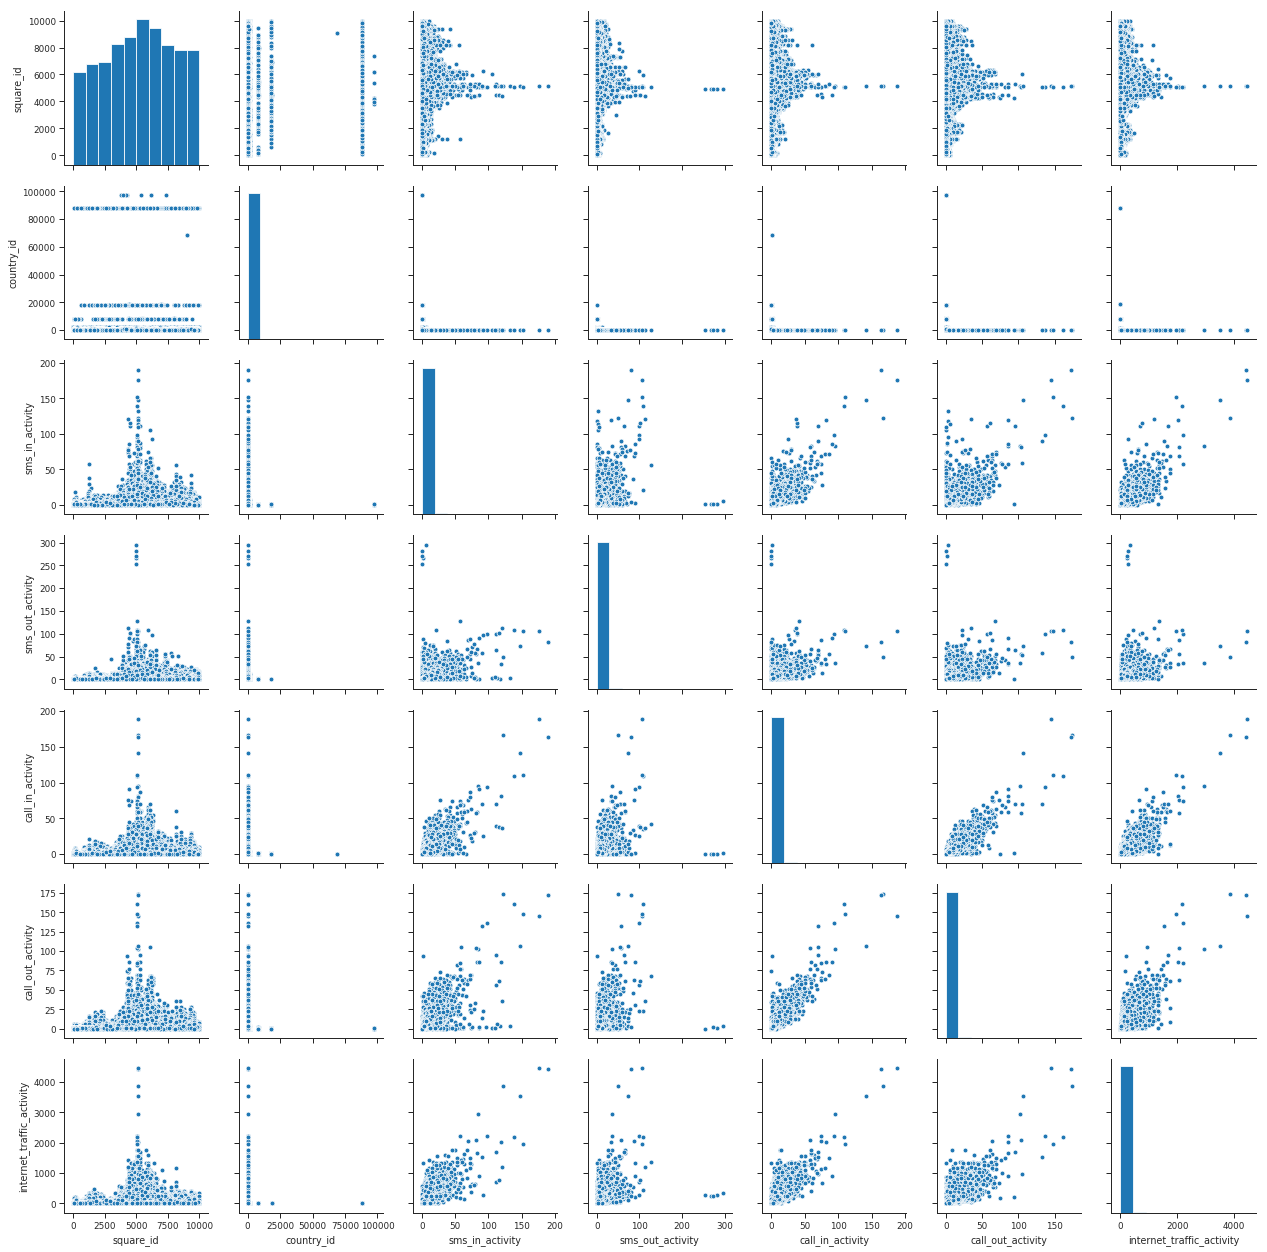

In [7]:
sns.pairplot(sci_.sample(500000))

## Data Cleaning


### Checking for missing values in the dataset**

We investigated data for missing values in the columns. Our observation revealed that 41%, 66%, 69%, 54% and 51%  of data observations for ```sms_in_activity``` ,```sms_out_activity```, ```call_in_activity```,  ```call_out_activity``` and ```internet_traffic_activity``` were missing respectively in the data set.

In [8]:
# checking for missing values
sci_.isnull().sum()

square_id                          0
time_interval                      0
country_id                         0
sms_in_activity              1981177
sms_out_activity             3210070
call_in_activity             3329423
call_out_activity            2611016
internet_traffic_activity    2488626
dtype: int64

In [9]:
#Checking for missing percentage of the data on all columns
k = {}
for i in sci_.columns:
    if sci_[i].isnull().sum() > 0:
        k[i] = round(((sci_[i].isnull().sum())/len(sci_))*100).astype(int)
print(k)

{'sms_in_activity': 41, 'sms_out_activity': 66, 'call_in_activity': 69, 'call_out_activity': 54, 'internet_traffic_activity': 51}


### Replace Missing Values

Since all the telecommunication activities took place within particular time intervals, the missing values could possibly be indicative that no activity took place at that particular time, hence, no record was taken. Thus, we decided to replace all the missing values with zero (0) for easy of computation and analysis. 

In [10]:
# replace missing values with 0
sci_['country_id'].fillna('Unknown',inplace=True)
sci_.fillna(0, inplace=True)

Lets take a look at the description of the data after filling the null values

In [11]:
sci_.isnull().sum()

square_id                    0
time_interval                0
country_id                   0
sms_in_activity              0
sms_out_activity             0
call_in_activity             0
call_out_activity            0
internet_traffic_activity    0
dtype: int64

**We visualize again the pairplot after filling the missing values.**

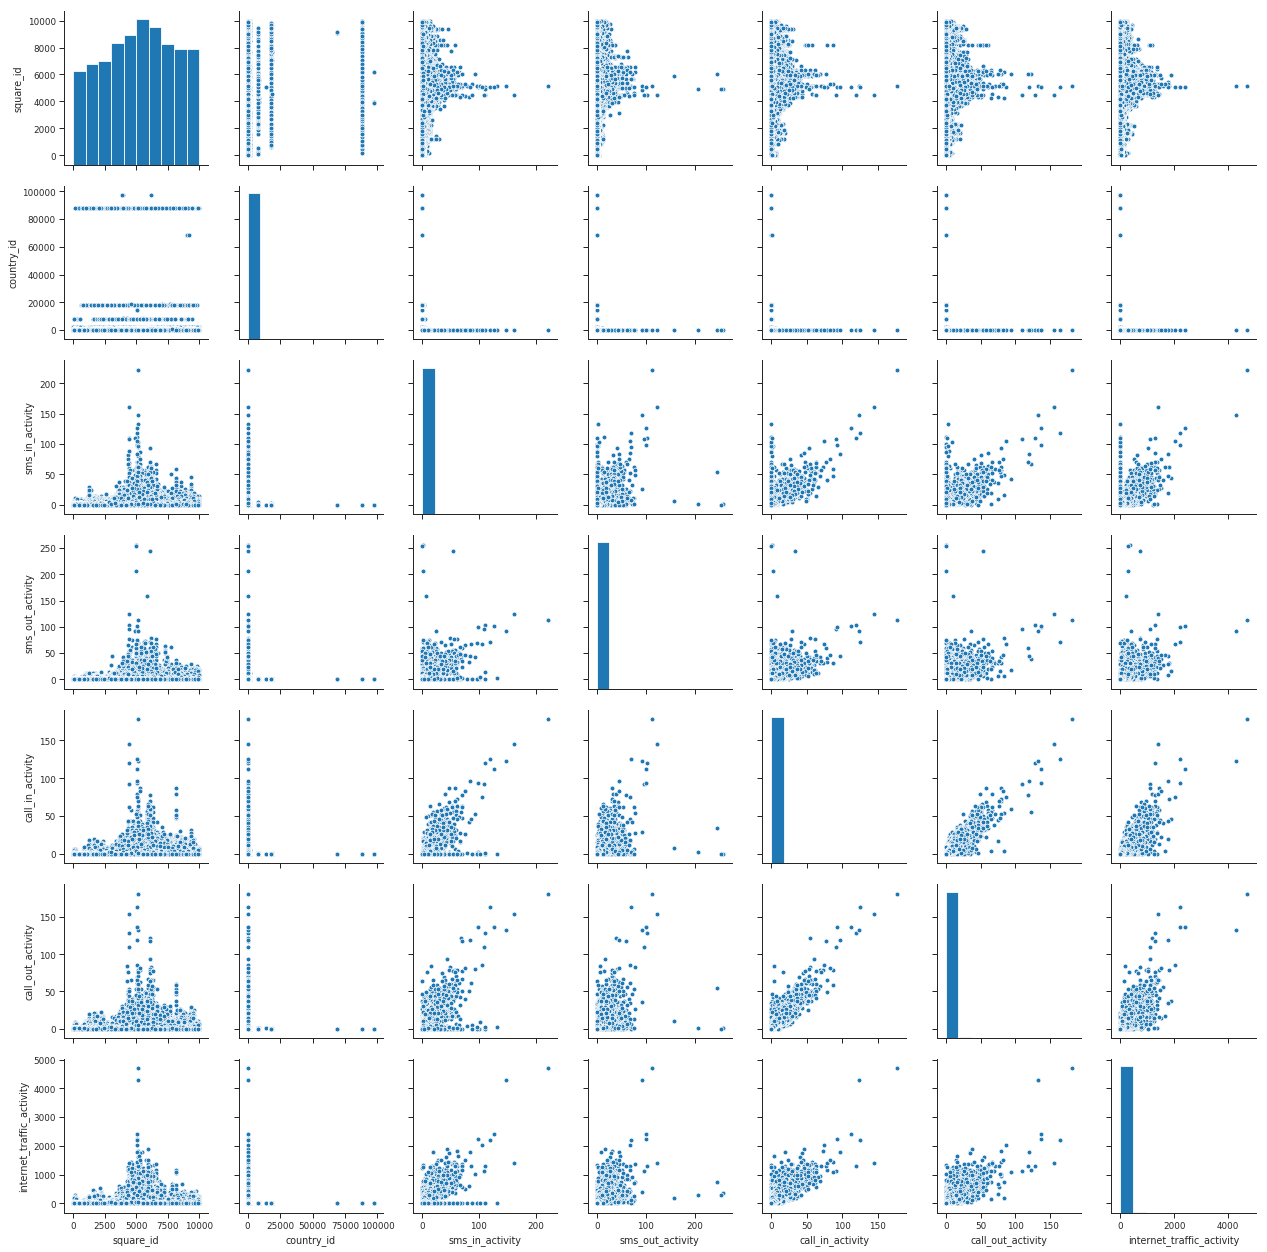

In [12]:
sns.pairplot(sci_.sample(500000))

## Data Exploration

In this section, we explored the individual features of our data through statistics and data visualization.

### Univariate Analysis

**Square ID**

There are 10000 unique square ids which represent the different grids in the province of Milan. Usually, sms and call activities are sent from and to these square ids to other countries outside Milan. 

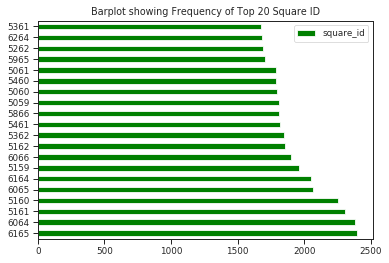

In [13]:
# check frquency of each square ids in the data set and display only first 20
pd.DataFrame(sci_['square_id'].value_counts().nlargest(20)).plot(kind='barh',color='g',title='Barplot showing Frequency of Top 20 Square ID')


**Country ID**

These ids represent individuals countries in which calls and sms are received from square ids, and and vice versa. 

In [15]:
cc_code = {1: 'United States' ,7: 'Russia' , 20: 'Egypt' , 27: 'South Africa' , 30: 'Greece' , 31: 'Netherlands' ,
32: 'Belgium' , 33: 'France' , 34: 'Spain' , 36: 'Hungary' , 39: 'Italy' , 40: 'Romania' , 41: 'Switzerland' ,
43: 'Austria' , 44: 'United Kingdom' , 45: 'Denmark' , 46: 'Sweden' , 47: 'Norway' , 48: 'Poland' , 49: 'Germany' ,
51: 'Peru' , 52: 'Mexico' , 53: 'Cuba' , 54: 'Argentina' , 55: 'Brazil' , 56: 'Chile' , 57: 'Colombia' ,
58: 'Venezuela' , 60: 'Malaysia' , 61: 'Australia' , 62: 'Indonesia' , 63: 'Philippines' , 64: 'New Zealand' ,
65: 'Singapore' , 66: 'Thailand' , 81: 'Japan' , 82: 'South Korea' , 84: 'Vietnam' , 86: 'China' , 90: 'Turkey' ,
91: 'India' , 92: 'Pakistan' , 93: 'Afghanistan' , 94: 'Sri Lanka' , 95: 'Myanmar' , 98: 'Iran' , 211: 'South Sudan' ,
212: 'Morocco' , 213: 'Algeria' , 216: 'Tunisia' , 218: 'Libya' , 220: 'Gambia' ,221: 'Senegal' , 222: 'Mauritania' ,
223: 'Mali' , 224: 'Guinea' , 225: 'Ivory Coast' , 226: 'Burkina Faso' , 227: 'Niger' , 228: 'Togo' , 229: 'Benin' ,
230: 'Mauritius' , 231: 'Liberia' , 232: 'Sierra Leone' , 233: 'Ghana' , 234: 'Nigeria' , 235: 'Chad' , 236: 'Central African Republic' ,
237: 'Cameroon' , 238: 'Cape Verde' , 239: 'Sao Tome and Principe' , 240: 'Equatorial Guinea' , 241: 'Gabon' ,
242: 'Republic of the Congo' , 243: 'Democratic Republic of the Congo' , 244: 'Angola' , 245: 'Guinea-Bissau' ,
246: 'British Indian Ocean Territory' , 248: 'Seychelles' , 249: 'Sudan' , 250: 'Rwanda' , 251: 'Ethiopia' ,
252: 'Somalia' , 253: 'Djibouti' ,     254: 'Kenya' , 255: 'Tanzania' , 256: 'Uganda' , 257: 'Burundi' ,
258: 'Mozambique' ,260: 'Zambia' , 261: 'Madagascar' , 262: 'Mayotte' , 263: 'Zimbabwe' , 264: 'Namibia' , 265: 'Malawi' ,
266: 'Lesotho' , 267: 'Botswana' , 268: 'Swaziland' , 269: 'Comoros' , 290: 'Saint Helena' , 291: 'Eritrea' , 297: 'Aruba' ,
298: 'Faroe Islands' , 299: 'Greenland' , 333: 'Yemen' , 334: 'Zambia' , 335: 'Zimbabwe' , 350: 'Gibraltar' , 351: 'Portugal' ,
352: 'Luxembourg' , 353: 'Ireland' , 354: 'Iceland' , 355: 'Albania' , 356: 'Malta' , 357: 'Cyprus' , 358: 'Finland' ,
359: 'Bulgaria' , 370: 'Lithuania' , 371: 'Latvia' , 372: 'Estonia' , 373: 'Moldova' , 374: 'Armenia' , 375: 'Belarus' ,
376: 'Andorra' , 377: 'Monaco' , 378: 'San Marino' , 379: 'Vatican' , 380: 'Ukraine' , 381: 'Serbia' , 382: 'Montenegro' ,
383: 'Kosovo' , 385: 'Croatia' , 386: 'Slovenia' , 387: 'Bosnia and Herzegovina' , 389: 'Macedonia' , 420: 'Czech Republic' ,
421: 'Slovakia' , 423: 'Liechtenstein' , 500: 'Falkland Islands' , 501: 'Belize' , 502: 'Guatemala' , 503: 'El Salvador' ,
504: 'Honduras' , 505: 'Nicaragua' , 506: 'Costa Rica' , 507: 'Panama' , 508: 'Saint Pierre and Miquelon' , 509: 'Haiti' ,
590: 'Saint Barthelemy' , 591: 'Bolivia' , 592: 'Guyana' , 593: 'Ecuador' , 595: 'Paraguay' , 597: 'Suriname' , 598: 'Uruguay' ,
599: 'Netherlands Antilles' , 670: 'East Timor' , 672: 'Antarctica' , 673: 'Brunei' , 674: 'Nauru' , 675: 'Papua New Guinea' ,
676: 'Tonga' , 677: 'Solomon Islands' , 678: 'Vanuatu' , 679: 'Fiji' , 680: 'Palau' , 681: 'Wallis and Futuna' ,
682: 'Cook Islands' , 683: 'Niue' , 685: 'Samoa' , 686: 'Kiribati' , 687: 'New Caledonia' , 688: 'Tuvalu' ,
689: 'French Polynesia' , 690: 'Tokelau' , 691: 'Micronesia' , 692: 'Marshall Islands' , 850: 'North Korea' ,
852: 'Hong Kong' , 853: 'Macau' ,  855: 'Cambodia' , 856: 'Laos' , 880: 'Bangladesh' , 886: 'Taiwan' , 960: 'Maldives' ,
961: 'Lebanon' , 962: 'Jordan' , 963: 'Syria' , 964: 'Iraq' , 965: 'Kuwait' , 966: 'Saudi Arabia' , 967: 'Yemen' ,
968: 'Oman' , 970: 'Palestine' , 971: 'United Arab Emirates' , 972: 'Israel' , 973: 'Bahrain' ,     974: 'Qatar' ,
975: 'Bhutan' , 976: 'Mongolia' , 977: 'Nepal' , 992: 'Tajikistan' , 993: 'Turkmenistan' , 994: 'Azerbaijan' ,
995: 'Georgia' , 996: 'Kyrgyzstan' , 998: 'Uzbekistan' , 1242: 'Bahamas' , 1246: 'Barbados' , 1264: 'Anguilla' ,
1268: 'Antigua and Barbuda' , 1284: 'British Virgin Islands' , 1340: 'U.S. Virgin Islands' , 1345: 'Cayman Islands' ,
1441: 'Bermuda' , 1473: 'Grenada' , 1649: 'Turks and Caicos Islands' , 1664: 'Montserrat' , 1670: 'Northern Mariana Islands' ,
1671: 'Guam' , 1684: 'American Samoa' , 1721: 'Sint Maarten' , 1758: 'Saint Lucia' , 1767: 'Dominica' ,
1784: 'Saint Vincent and the Grenadines' , 1809: 'Dominican Republic' , 1829: 'Dominican Republic' ,
1849: 'Dominican Republic' , 1868: 'Trinidad and Tobago' , 1869: 'Saint Kitts and Nevis' , 1876: 'Jamaica' ,
1939: 'Puerto Rico' , 441481: 'Guernsey' , 441534: 'Jersey' , 441624: 'Isle of Man' 
}

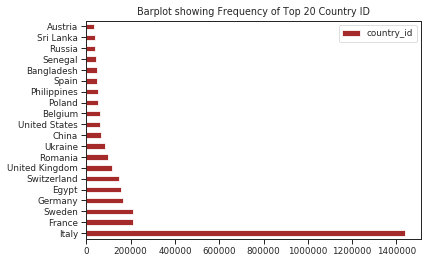

In [16]:
#map the country code to corresponding country name
sci_['country_id'] = sci_.country_id.map(cc_code)
# check frquency of each square ids in the data set and display only first 20
pd.DataFrame(sci_['country_id'].value_counts().nlargest(20)).plot(kind='barh',
                                    color='brown',title='Barplot showing Frequency of Top 20 Country ID')



From the above barplot, it is obvious that most of the activities are localized i.e most activities happeneed in Italy, hence, reason for its highest occurence as country. France and Sweden followed with equal frequency of occurenc in our country where ctivities took pace. Egypt is the fifth country in our top 20 countries and represents Africa as the country with the most activities followed by Senegal.

**sms-out-activity & sms_in_activity**

This is SMS out activity which is proportional to the amount of sent SMSs inside a given Square id during a
given Time interval. The SMSs are received in the nation identified by the Country code.

From the plot below, we can observe that sms out activities are centered at 0, meaning less sms out activities were recorded which confirms our initial assumption under section 2.2.  

**SMS-in activity**

This is activity proportional to the amount of received SMSs inside a given Square id and
during a given Time interval. The SMSs are sent from the nation identified by the Country code

Also, from below, we can see that less sms in activites took place, which we believe relates to our explanation under sms-out-activities. 

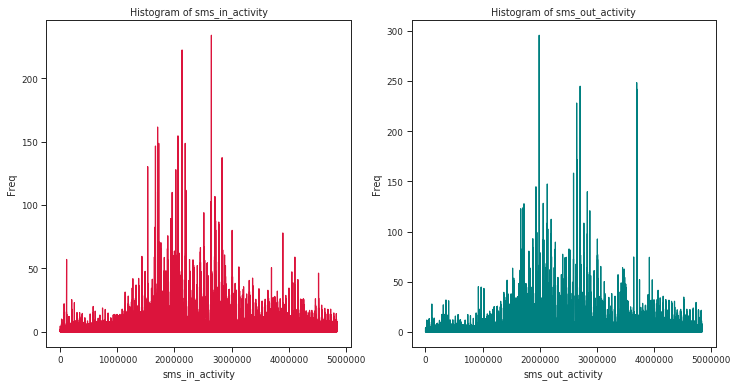

In [17]:
p = ['sms_in_activity','sms_out_activity']
c = ['crimson','teal']
fig = plt.figure(figsize=(12,6))
for i,j in enumerate(p):
    plt.subplot(1,2,i+1)
    sci_[j].plot(color=c[i],title=f'Histogram of {j}')
    plt.xlabel(j)
    plt.ylabel('Freq')
    i +=1
plt.show()


**call_in_activity** & **call_out_activity**

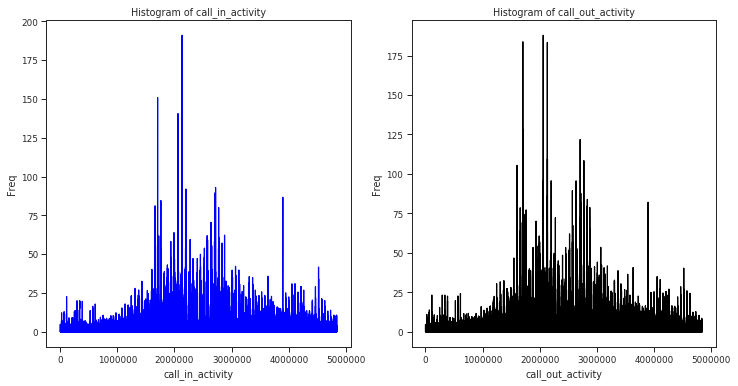

In [18]:
p = ['call_in_activity','call_out_activity']
c = ['b','k']
fig = plt.figure(figsize=(12,6))
for i,j in enumerate(p):
    plt.subplot(1,2,i+1)
    sci_[j].plot(color=c[i],title=f'Histogram of {j}')
    plt.xlabel(j)
    plt.ylabel('Freq')
    i +=1
plt.show()


### Adding New Columns

For better analysis, we decided to create new columns from the existings ones. As shown below, we are creating new columns that have potential give us interesting data analysys.

In [19]:
#  creating new features from time interval
sci_['date_'] = sci_.time_interval.dt.date

sci_['hour'] = sci_.time_interval.dt.hour

#  creating new feature from in and out call activities
sci_['calls'] = sci_['call_in_activity'] + sci_['call_out_activity']

#  creating new feature from in and out sms activities
sci_['sms'] = sci_['sms_in_activity'] + sci_['sms_out_activity']

#  creating new feature from all incoming activities
sci_['in_activities'] = sci_['call_in_activity'] + sci_['sms_in_activity'] 

#  creating new feature from all outgoing activities
sci_['out_activities'] = sci_['call_out_activity'] + sci_['sms_out_activity'] 

#  creating new feature from all incoming and outgoing activities
sci_['all_activities'] = sci_['sms'] + sci_['calls'] + sci_['internet_traffic_activity']

In [22]:
#set date as index.
sci_.set_index(['date_','time_interval'],inplace=True)
#Creating a data for clustering
new_data = sci_.copy()
sci_.head()

square_id country_id  sms_in_activity  \
date_      time_interval                                                      
2013-11-01 2013-11-01 00:00:00+01:00          1        NaN         0.081363   
           2013-11-01 00:00:00+01:00          1      Italy         0.141864   
           2013-11-01 00:10:00+01:00          1        NaN         0.136588   
           2013-11-01 00:10:00+01:00          1     France         0.000000   
           2013-11-01 00:10:00+01:00          1      Italy         0.278452   

                                      sms_out_activity  call_in_activity  \
date_      time_interval                                                   
2013-11-01 2013-11-01 00:00:00+01:00          0.000000          0.000000   
           2013-11-01 00:00:00+01:00          0.156787          0.160938   
           2013-11-01 00:10:00+01:00          0.000000          0.000000   
           2013-11-01 00:10:00+01:00          0.000000          0.000000   
           2013-11-01 00:10:00+01:00          0.119926          0.188777   

                                      call_out_activity  \
date_      time_interval                                  
2013-11-01 2013-11-01 00:00:00+01:00           0.000000   
           2013-11-01 00:00:00+01:00           0.052275   
           2013-11-01 00:10:00+01:00           0.027300   
           2013-11-01 00:10:00+01:00           0.000000   
           2013-11-01 00:10:00+01:00           0.133637   

                                      internet_traffic_activity  hour  \
date_      time_interval                                                
2013-11-01 2013-11-01 00:00:00+01:00                   0.000000     0   
           2013-11-01 00:00:00+01:00                  11.028366     0   
           2013-11-01 00:10:00+01:00                   0.000000     0   
           2013-11-01 00:10:00+01:00                   0.026137     0   
           2013-11-01 00:10:00+01:00                  11.100963     0   

                                         calls       sms  in_activities  \
date_      time_interval                                                  
2013-11-01 2013-11-01 00:00:00+01:00  0.000000  0.081363       0.081363   
           2013-11-01 00:00:00+01:00  0.213213  0.298651       0.302802   
           2013-11-01 00:10:00+01:00  0.027300  0.136588       0.136588   
           2013-11-01 00:10:00+01:00  0.000000  0.000000       0.000000   
           2013-11-01 00:10:00+01:00  0.322415  0.398378       0.467229   

                                      out_activities  all_activities  
date_      time_interval                                              
2013-11-01 2013-11-01 00:00:00+01:00        0.000000        0.081363  
           2013-11-01 00:00:00+01:00        0.209062       11.540230  
           2013-11-01 00:10:00+01:00        0.027300        0.163888  
           2013-11-01 00:10:00+01:00        0.000000        0.026137  
           2013-11-01 00:10:00+01:00        0.253563       11.821756

### Multivariate Analysis

**Correlation Between Features**

Calls, Sms & Internet_Traffic_activity are the variables are strongly correlated which seems obvious.This give us interesting analysis. Users who use one activity may be likely to use other activities. To avoid multicollinearity we will avoid incoming and outgoing sms and colls in our analysis. Instead we will use Totalsms and Total calls.

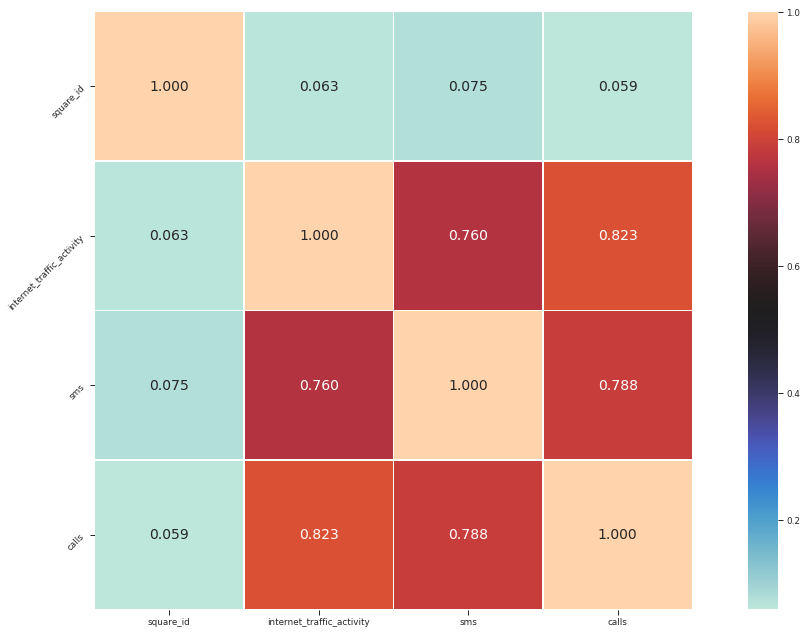

In [23]:
#Heatmap shows the correlation of the columns
df_cor = sci_[['square_id','internet_traffic_activity','sms','calls']]
df_cor = df_cor.corr()
dfheat = pd.DataFrame(df_cor)
plt.figure(figsize=(20,11))
ax = sns.heatmap(dfheat,cmap="icefire", linewidths=.5, 
                 annot=True ,annot_kws={'size':14} ,fmt=".3f" ,square = True)
plt.yticks(rotation=45)
plt.show()

**Variability of activity with respect to time of day**

We had a look at the calls, sms and internet connection. We used a pivot table to reach the goal of finding the statistics from activities in terms of grid id and time of the day.Taking the all_activities column from the table, with the corresponding hour of the day will give us top (peak) hours of the day.

In [24]:
#Create pivot table to calculate sum of all the all the activities grouped by hour of the day
df_all_activities = pd.pivot_table(sci_, index='hour', fill_value=0, values=['all_activities'], aggfunc=np.sum).unstack().reset_index()
df_all_activities.columns = ['type','hour', 'Total']
                     
#Take a look at the top 5 results  
df_all_activities.head(5)

,type,hour,Total
0,all_activities,0,3.946939e+06
1,all_activities,1,3.299749e+06
2,all_activities,2,2.821880e+06
3,all_activities,3,2.488233e+06
4,all_activities,4,2.253658e+06


As shown in the graph below, the peak time is 11 hours in the day time with some steady decline untill 23 hours. The least activities occurring at 5 hours in the morning. This could imply that Telecommunication activities gradually decrease at night hours with a steady rise in the day time.

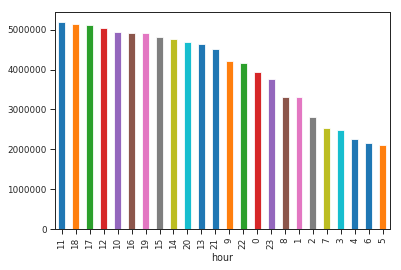

In [25]:
#groub by hours of the day and 
df_all_activities.groupby('hour')['Total'].sum().sort_values(ascending = False).plot('bar')

**Peak hours of the day with respect to sms in and out, call in and out, internet activity**

Taking the all_activities column from the table, with the corresponding hour of the day will give us top hours of the day.

Lets take a look at the top grids that recieved sms and calls

In [26]:
#Lets look 
df_events_by_grid = pd.pivot_table(sci_, index='hour',  values=['calls','sms','internet_traffic_activity'], aggfunc=np.sum).unstack().reset_index()
df_events_by_grid.columns = ['activity_type', 'hour', 'Freq_activities']
df_events_by_grid.head(10)

,activity_type,hour,Freq_activities
0,calls,0,101237.157178
1,calls,1,61082.185630
2,calls,2,43189.999801
3,calls,3,33378.831277
4,calls,4,26460.137084
5,calls,5,24338.824959
6,calls,6,30845.129026
7,calls,7,62339.042826
8,calls,8,158331.050484
9,calls,9,328107.163351


**Graph:Visualising Activities Versus Time**

We can see plots for all specific activities for the hours in the day. We can observe that Internet traffic activity initiated from the nation identified by the Country code is more than the sms and calls. Thus, we can conclude that there are more internet traffic activity generated than calls and sms.
Moreover, the three activities has the same trend.

<Figure size 432x432 with 0 Axes>

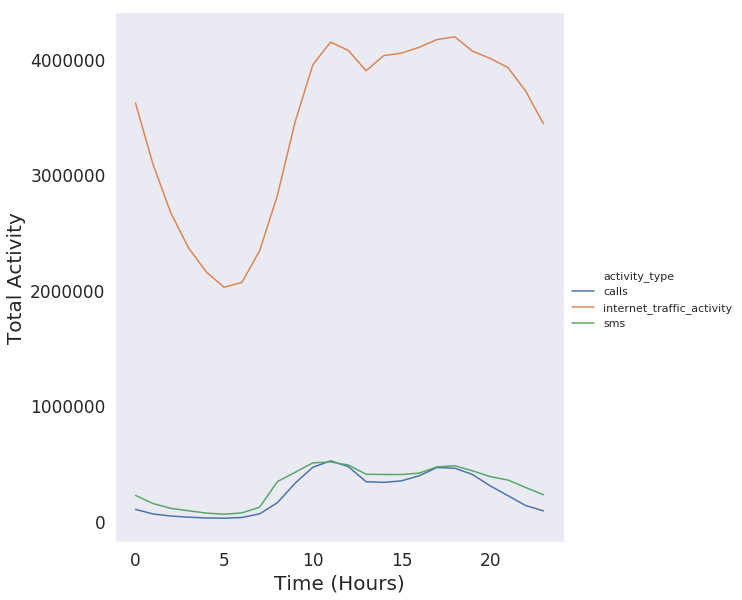

In [27]:
# Visualising activities versus time
plt.figure(figsize=(6,6))
sns.set(rc={'xtick.labelsize':17,'ytick.labelsize':17,'axes.labelsize':20  , "axes.grid":False})
sns.relplot(x="hour" , y="Freq_activities" , hue="activity_type" ,kind='line', height=8.5, aspect=1 ,data=df_events_by_grid)
plt.ylabel('Total Activity')
plt.xlabel('Time (Hours)')
plt.show()

**Variability of activity with respect to Grid Id.** 

We will take a look interms of calls, sms and internet connection. A pivot table is a table of statistics that summarizes the data of a more extensive table. This summary might include sums, averages, or other statistics, which the pivot table groups together in a meaningful way. We will make use of pivot table functions to reach the goal of finding the statistics from activities interms of grid id and time of the day.

**Milan GRID versus all activities**

Taking the all_activities column from the table, with the corresponding hour of the day will give us top grids of the day.

In [28]:
#Create pivot table to calculate sum of all the all the activities grouped by hour of the day
df_all_activities_grid = pd.pivot_table(sci_, index='square_id', fill_value=0, values=['all_activities'], aggfunc=np.sum).unstack().reset_index()
df_all_activities_grid.columns = ['type','Square_id', 'Total']
                     
#Take a look at the top 5 results  
df_all_activities_grid.head(5)

,type,Square_id,Total
0,all_activities,1,1720.998619
1,all_activities,2,1730.065386
2,all_activities,3,1739.716601
3,all_activities,4,1694.736564
4,all_activities,5,1547.666849


In [29]:
#top 20 grids with highest activity
df_top_activities_grid = df_all_activities_grid.groupby('Square_id')['Total'].sum().sort_values(ascending = True).tail(20)

In [30]:
#view top 20 grids
df_top_activities_grid

Square_id
5567    105790.089122
5857    106148.445732
5855    106165.843562
6072    106965.596475
5658    107140.190630
5956    109792.753184
6073    110620.416404
4654    111520.121459
4755    112272.007969
5458    113380.813334
4856    114005.332839
4857    121991.813318
5162    124664.323252
6064    126818.902641
5262    131322.882193
5955    135844.952632
5061    137435.483125
5758    143489.264069
5059    197968.343505
5161    274800.295462
Name: Total, dtype: float64

**Graph: Top 20 Grids with Highest Activity**

It was identified that grid 2801 receives the lowest amount of all telecommunication activities and grid 5161 does the majority task of all activities.

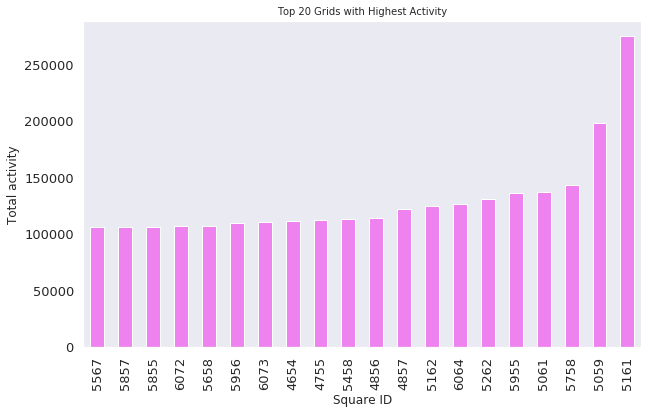

In [31]:
#Visualize to 20 grids
ax = df_top_activities_grid.plot(kind='bar', figsize=(10,6), color="violet", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Top 20 Grids with Highest Activity", fontsize=10)
ax.set_ylabel("Total activity", fontsize=12);
ax.set_xlabel("Square ID", fontsize=12);
plt.show()

**Top Grids with Highest Internet Traffic**

Taking the all_activities column from the table, with the corresponding hour of the day will give us top grids of the day.

In [32]:
#Create pivot table to calculate sum incoming calls at grids located in milan
df_grid_activities = pd.pivot_table(sci_, index='square_id', fill_value=0, values=['internet_traffic_activity'], aggfunc=np.sum).unstack().reset_index()
df_grid_activities.columns = ['type','Square_id', 'Total']
                     
#Take a look at the top 5 results  
df_grid_activities.head(5)


,type,Square_id,Total
0,internet_traffic_activity,1,1507.048349
1,internet_traffic_activity,2,1512.859757
2,internet_traffic_activity,3,1519.045771
3,internet_traffic_activity,4,1490.215500
4,internet_traffic_activity,5,1356.849530


In [33]:
#Generate the top 20 
top_20_incomingcall_to_grid = df_grid_activities.groupby('Square_id')['Total'].sum().sort_values().tail(20)
#View the top 20 incoming calls
top_20_incomingcall_to_grid

Square_id
4655     91705.525782
5855     92670.305654
5567     94077.963641
5658     94957.016607
6073     95786.078524
5857     95956.398025
5956     96991.027517
4856    100265.901737
4654    100311.356108
6064    101156.308696
4755    102314.142702
5458    102422.335722
5162    105435.146300
4857    108183.844626
5262    110195.112279
5061    118359.250283
5955    120642.442288
5758    127441.026357
5059    160148.770176
5161    237230.388004
Name: Total, dtype: float64

**Graph: Top 20 grids with High Internet Traffic**

Obviously, grid 5161 received the majority of the internet traffic activities as observed under all activities, however, we identified that grid 5239 received the least amount of internet traffic activities. 

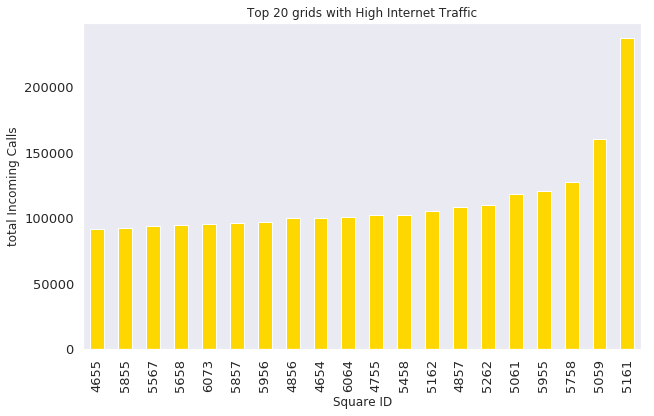

In [34]:
#Plot of top incoming calls from grids to milan grids
ax = top_20_incomingcall_to_grid.plot(kind='bar', figsize=(10,6), color="gold", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Top 20 grids with High Internet Traffic", fontsize=12)
ax.set_ylabel("total Incoming Calls", fontsize=12);
ax.set_xlabel("Square ID", fontsize=12);
plt.show()

**Distribution of Activities  Per Grids**

In [35]:
#Lets look 
df_activities_by_grid = pd.pivot_table(sci_, index='square_id',  values=['calls','sms','internet_traffic_activity'], aggfunc=np.sum).unstack().reset_index()
df_activities_by_grid.columns = ['activity_type', 'square_id', 'measure']
df_activities_by_grid.head(10)

,activity_type,square_id,measure
0,calls,1,89.353945
1,calls,2,90.878836
2,calls,3,92.502023
3,calls,4,84.937069
4,calls,5,79.649452
5,calls,6,92.502023
6,calls,7,92.502023
7,calls,8,92.502023
8,calls,9,92.502023
9,calls,10,72.839675


The following graph shows distribution of all the activities with respect to the grid id

<Figure size 864x432 with 0 Axes>

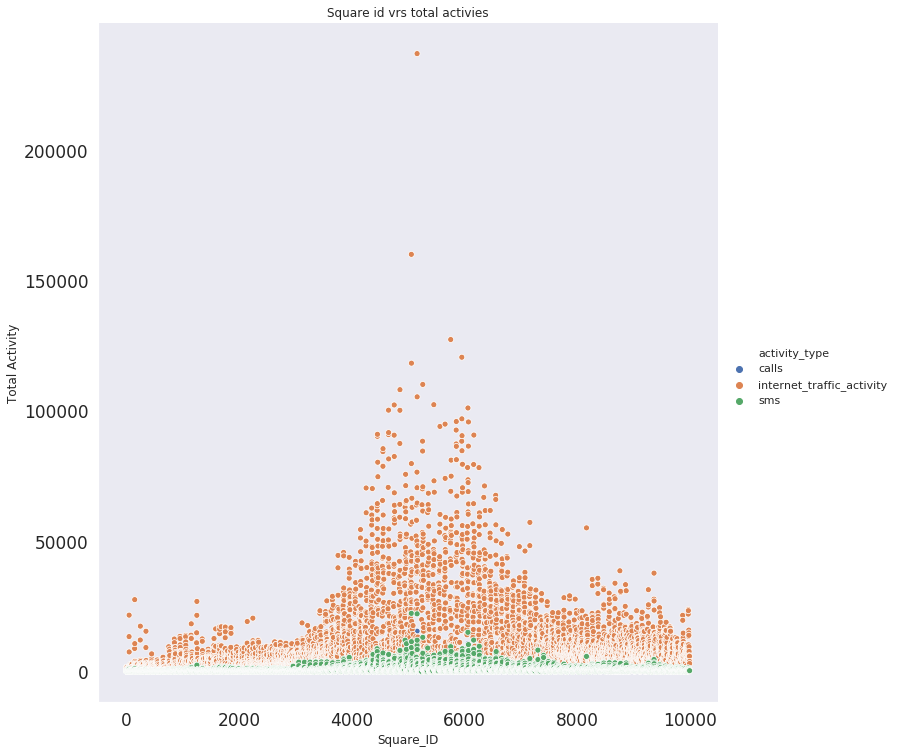

In [36]:
#Plotting every activity according to time of the day
plt.figure(figsize=(12,6))
sns.set(rc={'xtick.labelsize':17,'ytick.labelsize':17,'axes.labelsize':12  , "axes.grid":False})
sns.relplot(x="square_id" , y="measure" , hue="activity_type" ,kind='scatter', height=10.5, aspect=1 ,data=df_activities_by_grid)
plt.ylabel('Total Activity')
plt.xlabel('Square_ID')
plt.title('Square id vrs total activies')
plt.show()

**Graph: Visualizing Activity versus Grid**
The fillowing graph shows, internet service is a most utilized service across all the grids. However, it should be noted that the distribution of activities are the same across the grids.

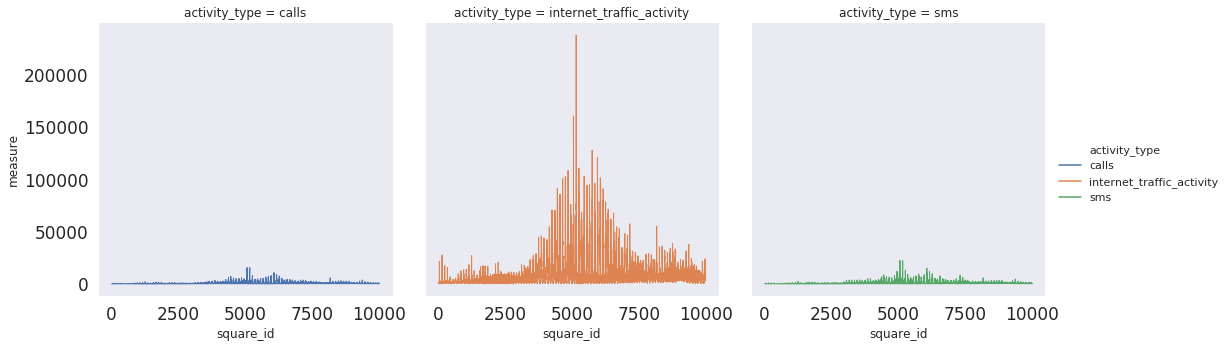

In [37]:
#Plotting every activity according to time of the day
sns.relplot(x="square_id", y="measure", hue="activity_type",col="activity_type" , col_wrap=3,kind="line",linewidth = 1,
            height=5, aspect=1, estimator=None, data=df_activities_by_grid)

### Variability of Activity Versus Country Connected. 
We will take a look interms of calls, sms and internet connection. A pivot table is a table of statistics that summarizes the data of a more extensive table. This summary might include sums, averages, or other statistics, which the pivot table groups together in a meaningful way. We will make use of pivot table functions to reach the goal of finding the statistics from activities interms of grid id and time of the day.

In [38]:
#Pivot table to calculate total number of activities per country connected
df_events_by_country = pd.pivot_table(sci_, index='country_id', columns='hour', values=['calls','sms','internet_traffic_activity'], aggfunc=np.sum).unstack().reset_index()
df_events_by_country.columns = ['event_type', 'hour', 'country_id', 'measure']
df_events_by_country.head(10)

,event_type,hour,country_id,measure
0,calls,0,Afghanistan,18.849556
1,calls,0,Albania,3.141593
2,calls,0,Algeria,6.283185
3,calls,0,Andorra,NaN
4,calls,0,Angola,0.000000
5,calls,0,Argentina,25.132741
6,calls,0,Armenia,NaN
7,calls,0,Aruba,NaN
8,calls,0,Australia,3.141593
9,calls,0,Austria,9.424778


In [39]:
#top 20 countries
top_20_countries = df_events_by_country.groupby('country_id')['measure'].sum().sort_values().tail(20)

In [41]:
#drop Italy from the list of countries
#remove all the local traffic
top_20_countries.drop('Italy', inplace = True)


In [42]:
#top 20 countries by connection
top_20_countries.head(10)

country_id
Senegal            8420.384349
Sri Lanka         10121.140878
Czech Republic    10812.056048
Poland            11592.064507
Philippines       16420.575706
Ukraine           17251.671685
Romania           17523.021219
Bangladesh        18441.922578
Belgium           18637.888913
Spain             18963.076484
Name: measure, dtype: float64

**Graph: Top 20 connected Countries by Tootal Activity**

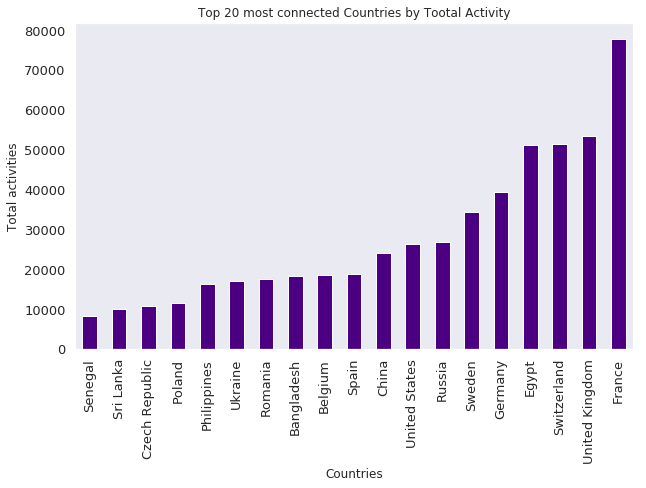

In [43]:
# Bar graph to show which are the top 20 countries connected
ax = top_20_countries.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Top 20 most connected Countries by Tootal Activity", fontsize=12)
ax.set_ylabel("Total activities", fontsize=12);
ax.set_xlabel("Countries", fontsize=12);
plt.show()

## Clustering


Unsupervised clustering can give us visualization of clusters. K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster based on similarity. We utilized grid id (square id) and internet traffic activity to cluster the data points. We can find clusters that are generating more internet traffic.

In [44]:
#dataset = new_data[[ 'country_id','square_id', 'sms_in_activity', 'sms_out_activity', 'call_in_activity', 'call_out_activity', 'internet_traffic_activity']]
dataset = new_data[[ 'square_id','internet_traffic_activity']]
#dataset.head()
dataset.head()

square_id  internet_traffic_activity
date_      time_interval                                                  
2013-11-01 2013-11-01 00:00:00+01:00          1                   0.000000
           2013-11-01 00:00:00+01:00          1                  11.028366
           2013-11-01 00:10:00+01:00          1                   0.000000
           2013-11-01 00:10:00+01:00          1                   0.026137
           2013-11-01 00:10:00+01:00          1                  11.100963

In [45]:
dataset =dataset.sample(frac=.02)

**Graph: Clusters Based on Squareid and Internet Traffic**

We utilized grid id (square id) and internet traffic activity to cluster the data points. It clustered the data points to 5 clustore. We can observe from the graph our data points are clustered based on the Internet traffic activity. We can find clusters that are generating more internet traffic. This can help us target customers based on their geo location and usage pattern.

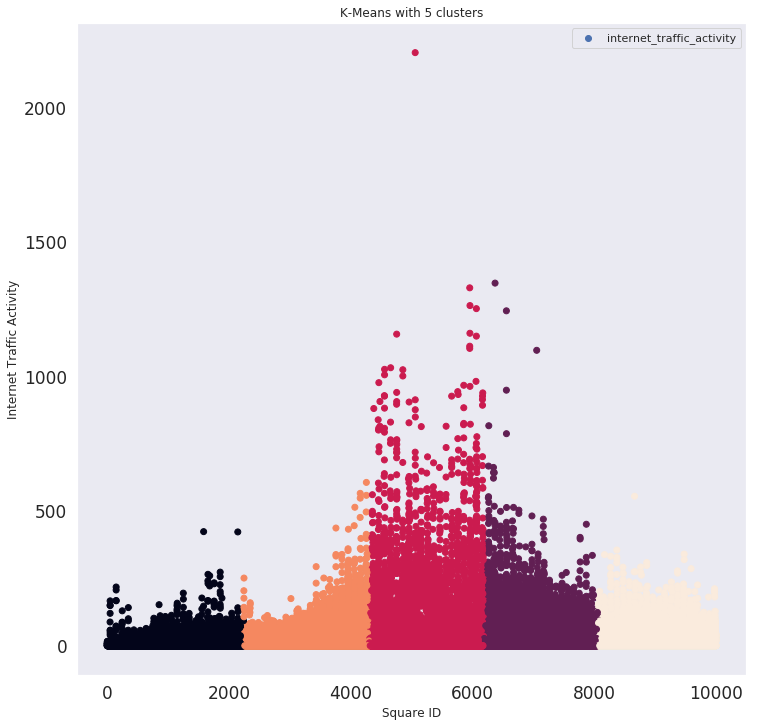

In [46]:
#kmeans clustering to cluster the data based on similarity
kmenas = KMeans(n_clusters=5, random_state=6)
#fit the data
kmenas.fit(dataset)
#create plot
plt.figure(figsize=(12,12))
#set x axis and y axis for the plot
plt.scatter(dataset['square_id'],dataset['internet_traffic_activity'],c= kmenas.labels_)
#set title
plt.title('K-Means with 5 clusters')
plt.xlabel('Square ID')
plt.ylabel('Internet Traffic Activity')
plt.legend()
plt.show()

## Conclusion

The dataset is very rich. However, due to resource constraint on day telecommunication data is utilized for this report.  Using the visualizations, we can infer on the variability of the volume of the activities with respect to time and space. This report can be extended by adding weather and population dataset to add more dimensions and better analysis. Moreover, utilizing more datasets can give us better visualization of the trend.